In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.decomposition import PCA

In [10]:
df_data = pd.read_csv('Data/cleaned_hotel_reviews.csv')
df_data.head()

,Review,Rating,label,clean_punc,lemmatized_review
0,nice hotel expensive parking got good deal sta...,4,positive,nice hotel expensive parking got good deal sta...,nice hotel expensive park get good deal stay h...
1,ok nothing special charge diamond member hilto...,2,negative,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,neutral,nice rooms not 4 experience hotel monaco seatt...,nice room not 4 experience hotel monaco seattl...
3,"unique, great stay, wonderful time hotel monac...",5,positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,positive,great stay great stay went seahawk game awesom...,great stay great stay go seahawk game awesome ...


In [11]:
negative_reviews = df_data[df_data['label'] == 'negative']['lemmatized_review']
positive_reviews = df_data[df_data['label'] == 'positive']['lemmatized_review']
neutral_reviews = df_data[df_data['label'] == 'neutral']['lemmatized_review']


vectorizer = TfidfVectorizer()
tfidf_negative = vectorizer.fit_transform(negative_reviews)
tfidf_positive = vectorizer.fit_transform(positive_reviews)
tfidf_neutral = vectorizer.fit_transform(neutral_reviews)

top_words_negative = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_negative.toarray(), axis=0))} 
top_words_positive = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_positive.toarray(), axis=0))}
top_words_neutral = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_neutral.toarray(), axis=0))}

wordcloud_negative = WordCloud().generate_from_frequencies(top_words_negative)
wordcloud_positive = WordCloud().generate_from_frequencies(top_words_positive)
wordcloud_neutral = WordCloud().generate_from_frequencies(top_words_neutral)

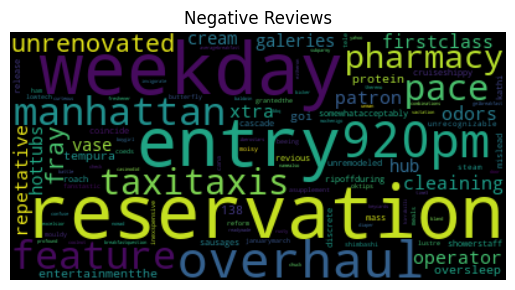

In [12]:
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")
plt.show()


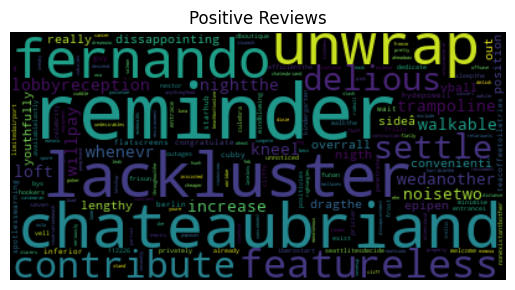

In [13]:
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")
plt.show()


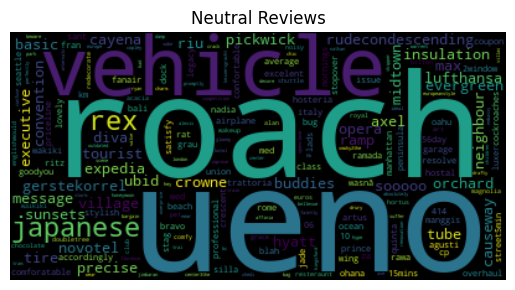

In [14]:
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")
plt.show()

In [15]:
label = ['positive', 'negative', 'neutral']

def encode_label(label):
    if label == 'positive':
        return 0
    elif label == 'negative':
        return 1
    else:
        return 2

In [16]:
df_data['label'] = df_data['label'].apply(encode_label)
df_data.head()

,Review,Rating,label,clean_punc,lemmatized_review
0,nice hotel expensive parking got good deal sta...,4,0,nice hotel expensive parking got good deal sta...,nice hotel expensive park get good deal stay h...
1,ok nothing special charge diamond member hilto...,2,1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,2,nice rooms not 4 experience hotel monaco seatt...,nice room not 4 experience hotel monaco seattl...
3,"unique, great stay, wonderful time hotel monac...",5,0,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,0,great stay great stay went seahawk game awesom...,great stay great stay go seahawk game awesome ...


In [17]:
x_train, x_test, y_train, y_test = train_test_split(df_data['lemmatized_review'], df_data['label'], test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((16392,), (4099,), (16392,), (4099,))

In [18]:
EMBEDDING_DIM = 15
MAXLEN = 32
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 20000
NUM_LABELS = 3

In [19]:
tokenizer = Tokenizer(num_words=MAX_EXAMPLES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(MAX_EXAMPLES, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(NUM_LABELS, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 15)            300000    
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 4)                 1924      
                                                                 
 dense_1 (Dense)             (None, 3)                 15        
                                                                 
Total params: 301,939
Trainable params: 301,939
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(x_train_pad, y_train, epochs=5, validation_data=(x_test_pad, y_test))

Epoch 1/5
513/513 [==============================] - 3s 4ms/step - loss: 0.6586 - accuracy: 0.7641 - val_loss: 0.4386 - val_accuracy: 0.8370
Epoch 2/5
513/513 [==============================] - 2s 4ms/step - loss: 0.3630 - accuracy: 0.8605 - val_loss: 0.4080 - val_accuracy: 0.8453
Epoch 3/5
513/513 [==============================] - 2s 4ms/step - loss: 0.2425 - accuracy: 0.9160 - val_loss: 0.4312 - val_accuracy: 0.8400
Epoch 4/5
513/513 [==============================] - 2s 4ms/step - loss: 0.1299 - accuracy: 0.9660 - val_loss: 0.4817 - val_accuracy: 0.8361
Epoch 5/5
513/513 [==============================] - 2s 4ms/step - loss: 0.0548 - accuracy: 0.9912 - val_loss: 0.5434 - val_accuracy: 0.8307


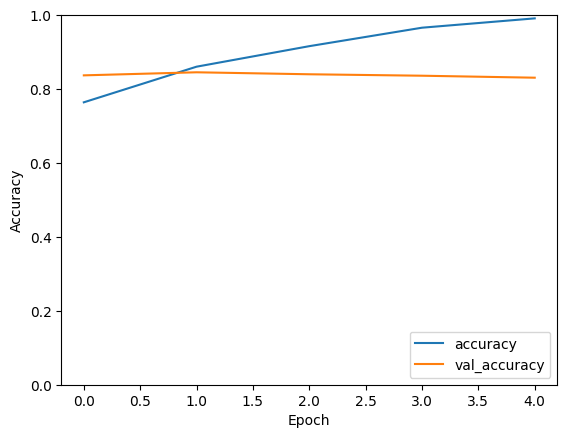

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [23]:
model.save('model.h5')

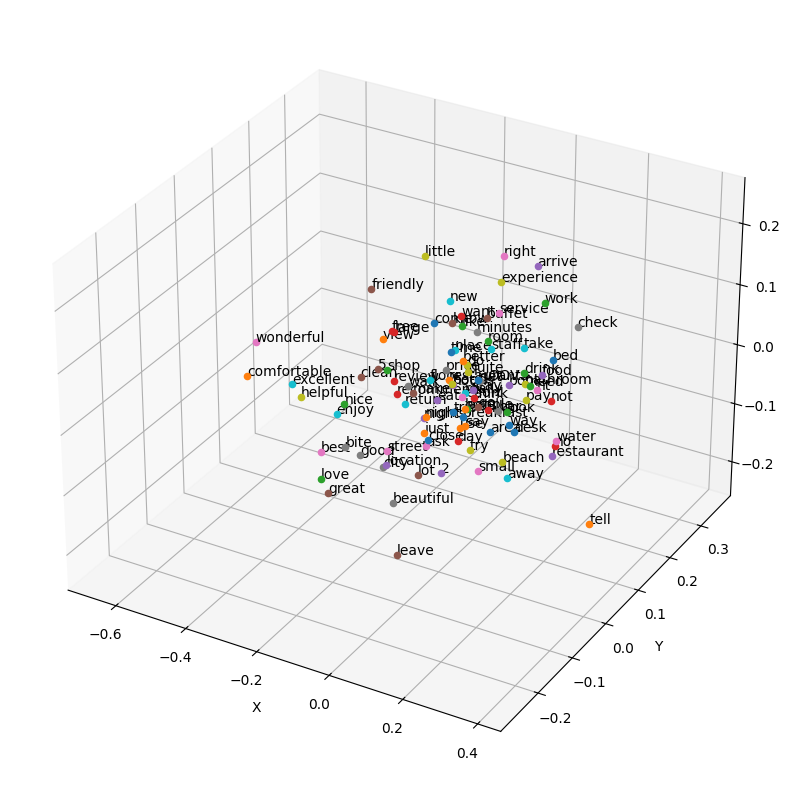

In [24]:
embeddings = model.layers[0].get_weights()[0]
pca = PCA(n_components=3, random_state=42)
embeddings_3d = pca.fit_transform(embeddings)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
word_index = tokenizer.word_index
n_words = min(100, len(word_index))

for word, index in list(word_index.items())[:n_words]:
    x, y, z = embeddings_3d[index]
    ax.scatter(x, y, z)
    ax.text(x, y, z, word)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()